In [ ]:
# Install required visualization library
!pip install matplotlib
import matplotlib.pyplot as plt
from collections import defaultdict

# Import PyTorch and its neural network modules
import torch
import torch.nn as nn
from torch.nn import functional as F
import time

# Check if GPU is available, otherwise use CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Purpose of this code:
# 1. Experiment with each of the parameters that
#    affect how the model is trained
# 2. See if there is a visual that can be used to better
#    show what the effect on the model it has
# 3. See & explain the effect on training the model

# Model hyperparameters
batch_size = 128        # Number of samples processed together
block_size = 64         # Size of the context window
max_iters = 300        # Maximum number of training iterations
eval_interval = 100    # How often to evaluate the model
learning_rate = 1e-3   # Step size for optimization
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # GPU/CPU setting
eval_iters = 200      # Number of iterations for evaluation
n_embd = 256          # Size of embedding vectors
n_head = 4            # Number of attention heads
n_layer = 6           # Number of transformer layers
dropout = 0.0         # Dropout rate for regularization
smoothing_factor = 0.95  # Factor for smoothing metrics

# Set random seed for reproducibility
torch.manual_seed(1337)

# Download the training text (Shakespeare's works)
!wget http://www.gutenberg.org/cache/epub/100/pg100.txt

# Read the text file
with open('pg100.txt', 'r', encoding='utf-8') as f1:
    text = f1.read()

# Create vocabulary from unique characters in text
chars = sorted(list(set(text)))
vocab_size = len(chars)

# Create mapping dictionaries
stoi = {ch: i for i, ch in enumerate(chars)}    # Character to integer mapping
itos = {i: ch for i, ch in enumerate(chars)}    # Integer to character mapping

# Define encoding and decoding functions
encode = lambda s: [stoi[c] for c in s]         # Convert text to integers
decode = lambda l: ''.join([itos[i] for i in l])  # Convert integers back to text

# Split data into training and validation sets
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(data))                        # Use 90% for training
train_data = data[:n]                           # Training set
val_data = data[n:]                             # Validation set

cuda
--2024-12-17 23:32:56--  http://www.gutenberg.org/cache/epub/100/pg100.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.gutenberg.org/cache/epub/100/pg100.txt [following]
--2024-12-17 23:32:57--  https://www.gutenberg.org/cache/epub/100/pg100.txt
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5638516 (5.4M) [text/plain]
Saving to: ‘pg100.txt.2’

pg100.txt.2         100%[===================>]   5.38M  2.96MB/s    in 1.8s    

2024-12-17 23:32:59 (2.96 MB/s) - ‘pg100.txt.2’ saved [5638516/5638516]



Model 1 Training time: 39.05 seconds


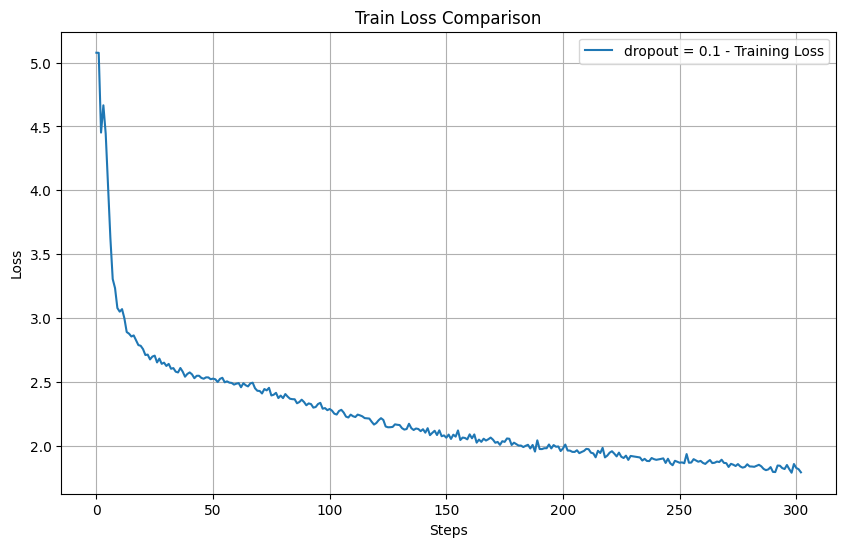

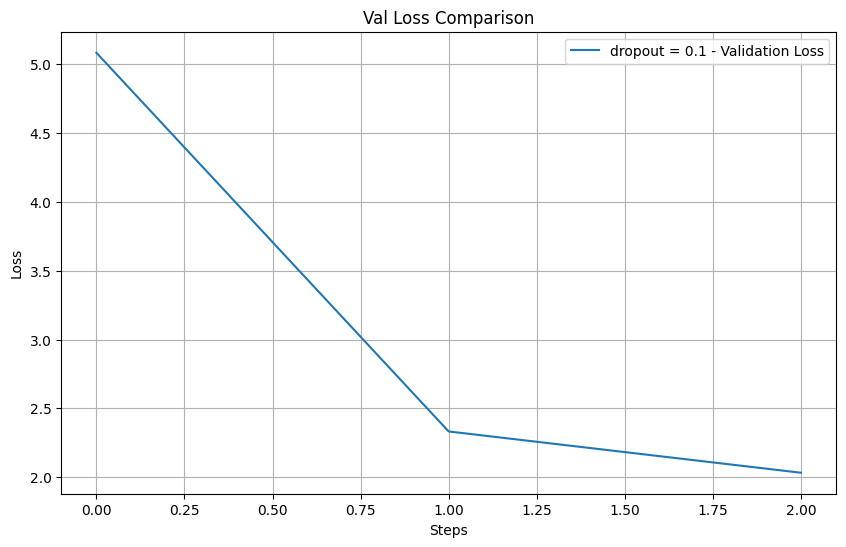

In [ ]:
# Data loading function for training and validation
def get_batch(split):
    # Generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))  # Random starting indices
    x = torch.stack([data[i:i+block_size] for i in ix])        # Input sequences
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])    # Target sequences (shifted by 1)
    x, y = x.to(device), y.to(device)                          # Move to GPU if available
    return x, y

# Decorator to disable gradient calculation for evaluation
@torch.no_grad()
def estimate_loss(model, split):
    # Calculate average loss over multiple batches
    out = {}
    model.eval()  # Set model to evaluation mode
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
        X, Y = get_batch(split)
        logits, loss = model(X, Y)
        losses[k] = loss.item()
    model.train()  # Set model back to training mode
    return losses.mean()

class Head(nn.Module):
    """ Single head of self-attention """
    def __init__(self, head_size):
        super().__init__()
        # Linear transformations for key, query, and value
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        # Register attention mask
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)    # Generate keys
        q = self.query(x)  # Generate queries
        # Compute attention scores
        wei = q @ k.transpose(-2,-1) * C**-0.5  # Scaled dot-product attention
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))  # Apply causal mask
        wei = F.softmax(wei, dim=-1)  # Convert to probabilities
        # Weighted aggregation of values
        v = self.value(x)
        out = wei @ v
        return out

class MultiHeadAttention(nn.Module):
    """ Multiple heads of self-attention in parallel """
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)  # Final projection layer

    def forward(self, x):
        # Concatenate outputs from all heads
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.proj(out)  # Project back to original dimension
        return out

class FeedForward(nn.Module):
    """ Simple feed-forward network """
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),  # Expand dimension
            nn.ReLU(),                       # Non-linearity
            nn.Linear(4 * n_embd, n_embd),  # Project back
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block combining attention and computation """
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)  # Self-attention layer
        self.ffwd = FeedForward(n_embd)                   # Feed-forward layer

    def forward(self, x):
        x = x + self.sa(x)      # Attention with residual connection
        x = x + self.ffwd(x)    # Feed-forward with residual connection
        return x

class BigramLanguageModel(nn.Module):
    """ Main language model """
    def __init__(self,n_head):
        super().__init__()
        # Embedding layers
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        # Transformer blocks
        self.blocks = nn.Sequential(
            Block(n_embd, n_head=n_head),
            Block(n_embd, n_head=n_head),
            Block(n_embd, n_head=n_head),
        )
        self.lm_head = nn.Linear(n_embd, vocab_size)  # Final layer for token prediction

    def forward(self, idx, targets=None):
        B, T = idx.shape
        # Get token and position embeddings
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb  # Combine embeddings
        x = self.blocks(x)     # Pass through transformer blocks
        logits = self.lm_head(x)  # Get predictions

        # Calculate loss if targets provided
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # Generate new tokens one at a time
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]  # Crop to last block_size tokens
            logits, _ = self(idx_cond)       # Get predictions
            logits = logits[:, -1, :]        # Focus on last token
            probs = F.softmax(logits, dim=-1)  # Get probabilities
            idx_next = torch.multinomial(probs, num_samples=1)  # Sample next token
            idx = torch.cat((idx, idx_next), dim=1)  # Append to sequence
        return idx

class MetricsTracker:
    """Class for tracking and visualizing training metrics across different model runs"""
    def __init__(self):
        # Initialize dictionaries to store different types of losses for each run
        self.train_losses = {}
        self.val_losses = {}
        self.gradient_norms = {}
        self.current_run = 'default'  # Track current experiment name

    def set_run(self, run_name):
        """Initialize a new experimental run with given name"""
        self.current_run = run_name
        # Create empty lists for storing metrics for this run
        self.train_losses[run_name] = []
        self.val_losses[run_name] = []
        self.gradient_norms[run_name] = []

    def update(self, *args, **kwargs):
        """Update metrics either from dictionary or individual values"""
        if len(args) == 1 and isinstance(args[0], dict):
            # Handle dictionary input
            metrics_dict = args[0]
            if 'train_loss' in metrics_dict:
                self.train_losses[self.current_run].append(metrics_dict['train_loss'])
            if 'gradient_norm' in metrics_dict:
                self.gradient_norms[self.current_run].append(metrics_dict['gradient_norm'])
        elif len(args) == 3:
            # Handle individual inputs (iteration, train_loss, val_loss)
            iter, train_loss, val_loss = args
            self.train_losses[self.current_run].append(train_loss)
            self.val_losses[self.current_run].append(val_loss)

    def plot_comparison(self, metric_type='train'):
        """Plot comparison of losses across different runs"""
        plt.figure(figsize=(10, 6))
        for run_name in self.train_losses.keys():
            if metric_type == 'train':
                losses = self.train_losses[run_name]
                plt.plot(losses, label=f'{run_name} - Training Loss')
            elif metric_type == 'val':
                losses = self.val_losses[run_name]
                plt.plot(losses, label=f'{run_name} - Validation Loss')
        plt.title(f'{metric_type.capitalize()} Loss Comparison')
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

def compute_gradient_norm(model):
    """Calculate the L2 norm of gradients for all model parameters"""
    total_norm = 0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    return total_norm

def train_model(model, optimizer, max_iters, eval_interval, metrics_tracker):
    """Main training loop for the model"""
    for iter in range(max_iters):
        # Evaluate model periodically
        if iter % eval_interval == 0:
            train_loss = estimate_loss(model, 'train')
            val_loss = estimate_loss(model, 'val')
            metrics_tracker.update(iter, train_loss, val_loss)
            #print(f"step {iter}: train loss {train_loss:.4f}, val loss {val_loss:.4f}")

        # Get batch of training data
        xb, yb = get_batch('train')

        # Forward and backward passes
        logits, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        # Track training metrics
        metrics_tracker.update({
            'train_loss': loss.item(),
            'gradient_norm': compute_gradient_norm(model)
        })


# Initialize metrics tracker and run experiments with different dropout values
metrics_tracker = MetricsTracker()

# Train model dropout = 0.1
#dropout = 0.1
model1 = BigramLanguageModel(n_head)
model1.to(device)
optimizer1 = torch.optim.AdamW(model1.parameters(), lr=learning_rate)
metrics_tracker.set_run('dropout = 0.1')
start_time = time.time()
train_model(model1, optimizer1, max_iters, eval_interval, metrics_tracker)
print(f"Model 1 Training time: {time.time() - start_time:.2f} seconds")
'''
#Train model dropout = 0.2
dropout = 0.2
model2 = BigramLanguageModel(n_head)
model2.to(device)
optimizer2 = torch.optim.AdamW(model2.parameters(), lr=learning_rate)
metrics_tracker.set_run('dropout = 0.2')
start_time = time.time()
train_model(model2, optimizer2, max_iters, eval_interval, metrics_tracker)
print(f"Model 2 Training time: {time.time() - start_time:.2f} seconds")

#Train model dropout = 0.3
dropout = 0.3
model3 = BigramLanguageModel(n_head)
model3.to(device)
optimizer3 = torch.optim.AdamW(model3.parameters(), lr=learning_rate)
metrics_tracker.set_run('dropout = 0.3')
start_time = time.time()
train_model(model3, optimizer3, max_iters, eval_interval, metrics_tracker)
print(f"Model 3 Training time: {time.time() - start_time:.2f} seconds")
'''
# Visualize results
metrics_tracker.plot_comparison('train')
metrics_tracker.plot_comparison('val')


In [ ]:
# Generate text from the model
#context = torch.zeros((1, 1), dtype=torch.long, device=device)
#generated = decode(model.generate(context, max_new_tokens=2000)[0].tolist())
#print(generated)